# Real-time Tweet Analysis: Eurovision Song Contest 2022 - Final
**GOAL**: Find the most tweeted countries from the show **Eurovision Song Contest**, inside the official hashtag #Eurovision.

During the course of the show, the following code will evaluate the most tweeted countries within the official hashtag of the program.



**NOTES**:
* The following code will evaluate tweets in these languages: English, French, Italian, Dutch, Spanish, Portuguese.
* The following notebook is for educational purposes only.
* The project is still subject to checks and modifications. Additions and corrections will be made for future analysis.

## Libraries

In [1]:
from pyspark import SparkContext
from pyspark.sql import SparkSession, Row
from pyspark.streaming import StreamingContext
from time import time
import datetime as dt
import string
import seaborn as sns
import matplotlib.pyplot as plt

## Variables

In [56]:
BATCH_DURATION = 5
PORT = 9999
hostname = "localhost"
checkpoint = "/home/daniel/checkpoint"
fig_esc_before = "res/Eurovision_before.jpg"
fig_esc_after = "res/Eurovision_after.jpg"
pd_save = "res/Eurovision.csv"

## Spark instance and Streaming Context

In [3]:
sc = SparkContext()
ssc = StreamingContext(sc, BATCH_DURATION)
ssc.checkpoint(checkpoint)
lines = ssc.socketTextStream(hostname, PORT)

## Spark Session

In [4]:
def get_spark_session(spark_context):
    if ("sqlContextSingletonInstance" not in globals()):
        globals()["sqlContextSingletonInstance"] = SparkSession \
                            .builder \
                            .config(conf=spark_context) \
                            .getOrCreate()
    return globals()["sqlContextSingletonInstance"]

## Data preprocessing

In [5]:
def aggregate_count(new_values, total_sum):
    return sum(new_values) + (total_sum or 0)

In [6]:
# Remove any hashtags and punctuation and make the word lowercase with the first letter uppercase
def clean_hashtag(word):
    return word.lower().capitalize().translate(str.maketrans('', '', string.punctuation))

In [7]:
# Replace surnames or aliases with the names in the list
def change_name(name):
    if name in list(translation.keys()):
        return translation[name]
    else:
        return name

## Timestamp

In [8]:
def format_timestamp(x):
    return x.strftime("%Y-%m-%d %H:%M:%S")

In [9]:
def print_timedelta(date_start):
    print("Start tweet analysis: " + format_timestamp(date_start))
    date_now = dt.datetime.now()
    print("Last update: " + format_timestamp(date_now))
    delta = date_now - date_start
    delta_seconds = delta.seconds
    delta_hours = delta_seconds/3600
    delta_minutes = (delta_seconds/60)%60
    delta_seconds = delta_seconds%60
    if delta.days!=0:
        print("Elapsed time: %d days, %d hours, %d minutes, %d seconds" 
                % (delta.days, delta_hours, delta_minutes, delta_seconds))
    else:
        print("Elapsed time: %d hours, %d minutes, %d seconds" 
                % (delta_hours, delta_minutes, delta_seconds))

## RDD processing

In [10]:
def process_rdd(time, rdd):
    if (rdd.count()>0):
        spark = get_spark_session(rdd.context.getConf())
        row_rdd = rdd.map(lambda w: Row(Country=w[0], Count=w[1]))
        table_df = spark.createDataFrame(row_rdd)
        table_df = table_df.createOrReplaceTempView("TempView")

In [11]:
def from_list_to_view(time, names_list, view_name):
    if (len(names_list)>0):
        names_rdd = sc.parallelize(names_list)
        spark = get_spark_session(names_rdd.context.getConf())
        row_rdd = names_rdd.map(lambda w: Row(Country=w))
        table_df = spark.createDataFrame(row_rdd)
        table_df = table_df.createOrReplaceTempView(view_name)

## Countries

List of contestants.

In [12]:
countries = ["Albania", "Armenia", "Australia", "Austria", "Azerbaijan", "Belgium", "Bulgaria", 
             "Croatia", "Cyprus", "Czech_Republic", "Denmark", "Estonia","Finland", "France", 
             "Germany", "Georgia", "Greece", "Iceland", "Ireland", "Israel", "Italy",
             "Latvia", "Lithuania", "Malta", "Moldova", "Montenegro", "Netherlands", "North_Macedonia", 
             "Norway", "Poland", "Portugal", "Romania", "San_Marino", "Serbia", "Slovenia", 
             "Spain", "Sweden", "Switzerland", "United_Kingdom", "Ukraine"]
from_list_to_view(time, countries, "countries_df")

Dictionary with translation in: English, French, Italian, Dutch, Spanish, Portuguese.

In [13]:
translation = {"Albanien":"Albania","Albanie":"Albania",
              "Armenien":"Armenia", "Armenie":"Armenia",
              "Australien":"Australia","Australie":"Australia",
              "Osterreich":"Austria","Autriche":"Austria", 
              "Aserbaidschan":"Azerbaijan","Azerbaijao":"Azerbaijan","Azerbaiyan":"Azerbaijan",
              "Azerbaidjan":"Azerbaijan","Azerbaigian":"Azerbaijan", 
              "Belgien":"Belgium", "Belgica":"Belgium","Belgique":"Belgium","Belgio":"Belgium", 
              "Bulgarien":"Bulgaria","Bulgarie":"Bulgaria", 
              "Kroatien":"Croatia","Croacia":"Croatia","Croatie":"Croatia","Croazia":"Croatia", 
              "Zypern":"Cyprus","Chipre":"Cyprus","Chypre":"Cyprus","Cipro":"Cyprus", 
              "Tschechien":"Czech_Republic","Chequia":"Czech_Republic","Checa":"Czech_Republic",
              "Tchequie":"Czech_Republic","Ceca":"Czech_Republic","Czech":"Czech_Republic", 
              "Dinamarca":"Denmark", "Danemark":"Denmark","Danimarca":"Denmark", 
              "Estland":"Estonia","Estonie":"Estonia",
              "Finnland":"Finland","Finlande":"Finland","Finlandia":"Finland", 
              "Frankreich":"France","Franca":"France","Francia":"France", 
              "Georgien":"Georgia","Georgie":"Georgia",
              "Deutschland":"Germany","Alemanha":"Germany","Alemania":"Germany",
              "Allemagne":"Germany","Germania":"Germany", 
              "Griechenland":"Greece","Grece":"Greece", "Grecia":"Greece", 
              "Island":"Iceland","Islandia":"Iceland","Islande":"Iceland", "Islanda":"Iceland", 
              "Irland":"Ireland","Irlanda":"Ireland", 
              "Israele":"Israel", 
              "Italien":"Italy","Italie":"Italy","Italia":"Italy",
              "Lettland":"Latvia","Letonia":"Latvia", "Lettonie":"Latvia","Lettonia":"Latvia", 
              "Litauen":"Lithuania","Lituanie":"Lithuania", "Lituania":"Lithuania", 
              "Malte":"Malta", 
              "Moldau":"Moldova","Moldavie":"Moldova", "Moldavia":"Moldova", 
              "Niederlande":"Nethelands","Baixos":"Netherlands","Bajos":"Netherlands",
              "Paysbas":"Netherlands", "Bassi":"Netherlands", 
              "Nordmazedonien":"North_Macedonia","Macedoine":"North_Macedonia", "Macedonia":"North_Macedonia", 
              "Norwegen":"Norway","Noruega":"Norway","Norvege":"Norway","Norvegia":"Norway", 
              "Polen":"Poland","Pologne":"Poland", "Polonia":"Poland", 
              "Portogallo":"Portugal", 
              "Rumanien":"Romania","Romenia":"Romania", "Rumania":"Romania","Roumanie":"Romania", 
              "Saintmarin":"San_Marino","Marino":"San_Marino", 
              "Serbien":"Serbia","Servia":"Serbia", "Serbie":"Serbia", 
              "Slowenien":"Slovenia","Eslovenia":"Slovenia","Slovenie":"Slovenia", 
              "Spanien":"Spain","Espanha":"Spain","Espana":"Spain","Spagna":"Spain", 
              "Schweden":"Sweden","Suecia":"Sweden","Suede":"Sweden", "Svezia":"Sweden", 
              "Schweiz":"Switzerland","Suica":"Switzerland", "Suiza":"Switzerland","Suisse":"Switzerland", 
              "Svizzera":"Switzerland", 
              "Vereinigtes":"United_Kingdom", "Reino":"United_Kingdom", "Royaumeuni":"United_Kingdom",
              "Regno":"United_Kingdom","Kingdom":"United_Kingdom","Uk":"United_Kingdom", 
              "Ucrania":"Ukraine", "Ucraina":"Ukraine"}

## Discretized Stream

In [14]:
lines.flatMap(lambda text: text.split()) \
        .map(lambda word: change_name(clean_hashtag(word))) \
        .filter(lambda word: word in countries) \
        .map(lambda word: (word, 1)) \
        .updateStateByKey(aggregate_count) \
        .foreachRDD(process_rdd)

## Start Streaming

Before the beginning of the show, start the script named **tweets_stream.py** from the terminal, then start Streaming.

In [15]:
ssc.start()

print("Start tweeet analysis...")
start = dt.datetime.now()

Start tweeet analysis...


## Tweet counter

### Query

In [59]:
query_tweet_countries = "SELECT * FROM TempView \
                       WHERE Country IN \
                           (SELECT Country FROM countries_df) \
                       ORDER BY count DESC"

### Tweet analysis

In [69]:
def tweet_analysis(query, fig_name, figsize=(12,10), palette=None, title=None):
    df_top = get_spark_session(sc).sql(query)
    df_top.show(15)
    df_top_pd = df_top.toPandas()
    df_top_pd.to_csv(pd_save)

    plt.figure(figsize=figsize)
    sns.barplot(x="Count", y="Country", data=df_top_pd.loc[0:14,:], palette=palette).set(title=title)
    plt.grid()
    plt.savefig(fig_name)
    plt.show()

Analysis before jury results

Start tweet analysis: 2022-05-14 20:45:31
Last update: 2022-05-15 00:02:39
Elapsed time: 3 hours, 17 minutes, 7 seconds
+--------------+-----+
|       Country|Count|
+--------------+-----+
|       Ukraine|10910|
|         Spain|10243|
|       Moldova| 9987|
|United_Kingdom| 8625|
|        France| 7765|
|         Italy| 7111|
|     Australia| 7037|
|        Norway| 6043|
|        Serbia| 6009|
|      Portugal| 4216|
|       Romania| 4205|
|       Finland| 4161|
|        Sweden| 4046|
|       Armenia| 3496|
|       Germany| 3324|
+--------------+-----+
only showing top 15 rows



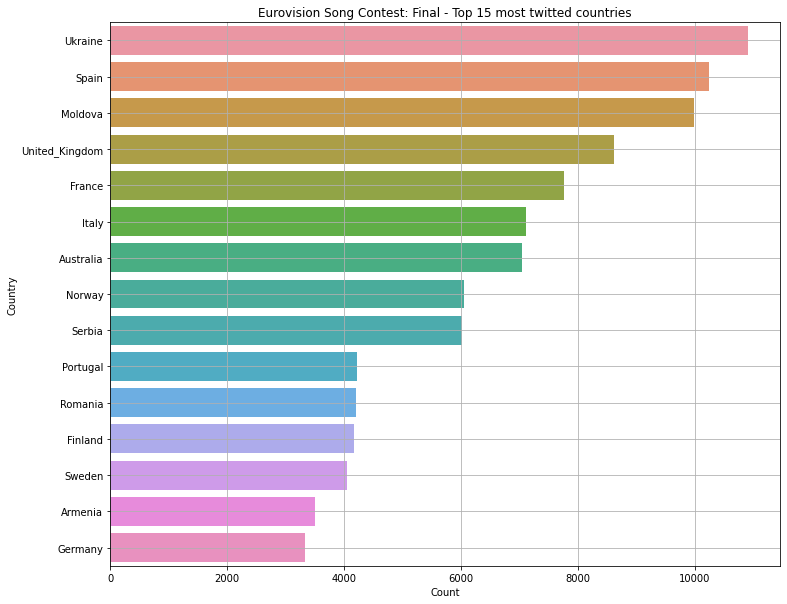

In [86]:
print_timedelta(start)
tweet_analysis(query_tweet_countries, fig_esc_before, 
               title="Eurovision Song Contest: Final - Top 15 most twitted countries")

Analysis during and after the results and winner announcement

Start tweet analysis: 2022-05-14 20:45:31
Last update: 2022-05-15 01:13:27
Elapsed time: 4 hours, 27 minutes, 55 seconds
+--------------+-----+
|       Country|Count|
+--------------+-----+
|United_Kingdom|25591|
|       Ukraine|24664|
|         Spain|15906|
|       Moldova|13042|
|        France|11614|
|     Australia| 9434|
|         Italy| 9104|
|        Serbia| 8581|
|       Germany| 6907|
|        Norway| 6618|
|      Portugal| 6439|
|        Sweden| 5724|
|       Romania| 4958|
|       Finland| 4549|
|       Armenia| 4152|
+--------------+-----+
only showing top 15 rows



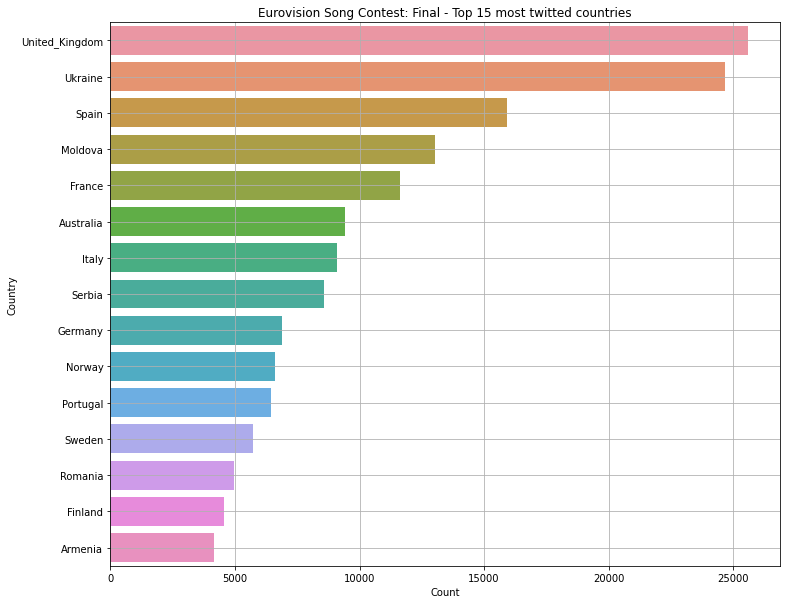

In [100]:
print_timedelta(start)
tweet_analysis(query_tweet_countries, fig_esc_after,
               title="Eurovision Song Contest: Final - Top 15 most twitted countries")

In [98]:
#ssc.stop()
#!sudo kill $(sudo lsof -t -i:9999)